In [581]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score
from sklearn import preprocessing


# Whether to read realistic data file or nooutliers data file. 
df = pd.read_csv('realistic_data.csv')
#df = pd.read_csv('nooutliers_data.csv')

# Whether to plot everything or not
PLOT_EDA2 = False

## Pre-process cleaned data

In [582]:
# Create columns for variables that have a value
for var in df["variable"].unique():
    df['%s'%var] = np.where(df['variable'] == var, df['value'], np.NaN)

# Split the date-time in seperate columns, transform to a datetime format
df[['date', 'time']] = df['time'].str.split(' ', 1, expand=True)
df['time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S.%f')

# Print example
df.head()

,Unnamed: 0,index,Unnamed: 0.1,id,time,variable,value,mood,circumplex.arousal,circumplex.valence,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,date
0,0,0,1,1,2014-02-26 13:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
1,1,1,2,1,2014-02-26 15:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
2,2,2,3,1,2014-02-26 18:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
3,3,3,4,1,2014-02-26 21:00:00,mood,7.0,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
4,4,4,5,1,2014-02-27 09:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-27


## Group by day, merge all users in one dataset

In [583]:
# Pick one sample user

def create_merged_dataset(df):
    frames = []
    unique_users = df['id'].unique()
    for uu in unique_users:
        df1 = df[df['id'] == uu]
        df_avg = pd.DataFrame()

        # Average over the day
        take_mean = set(("mood", "activity", "circumplex.arousal", "circumplex.valence"))

        # Total time everyday
        take_sum = set(("screen", "appCat.builtin","appCat.communication","appCat.entertainment", 
                        "appCat.finance", "appCat.game", "appCat.office", "appCat.other", "appCat.social",  
                        "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather"))

        # Amount of calls or texts a day
        take_count = set(("call", "sms"))

        for var in df["variable"].unique():
            df2 = df1[df1[var].notna()]
            if var in take_mean:
                df_mean = df2.groupby('date').mean()
                df_avg[var] = df_mean[var]
            if var in take_sum:
                df_sum = df2.groupby('date').mean()
                df_avg[var] = df_sum[var]
            if var in take_count:
                df_count = df2.groupby('date').count()
                df_avg[var] = df_count[var]
        
        df_avg["id"] = uu
        
        # Provide benchmark mood by taking mood from day before
        df_avg["Benchmark_mood_pred"] = df_avg.mood.shift(1)
        
        frames.append(df_avg)
        

    df_merged = pd.concat(frames)
    col = df_merged.pop("id")
    df_merged.insert(0, col.name, col)
    return df_merged

df_merged = create_merged_dataset(df)
#print('Dataset with all id, not yet aggregated the values for different time periods')
dfa1401 = df_merged[df_merged['id']=='AS14.01']
print('length of merged dataset:', len(df_merged))
print(df_merged.isna().sum())
df_merged.head()

length of merged dataset: 1268
id                         0
mood                       0
circumplex.arousal         0
circumplex.valence         2
activity                 118
screen                   100
call                     528
sms                      840
appCat.builtin           111
appCat.communication     121
appCat.entertainment     445
appCat.finance          1062
appCat.game             1079
appCat.office            998
appCat.other             165
appCat.social            306
appCat.travel            850
appCat.unknown          1013
appCat.utilities         844
appCat.weather          1157
Benchmark_mood_pred       27
dtype: int64


,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,-0.25,0.750000,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-27,1,6.333333,0.00,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.250000
2014-03-21,1,6.200000,0.20,0.200000,0.134050,81.254545,6.0,NaN,5.962021,47.019804,...,3.8294,NaN,57.402,29.968875,64.902404,39.064,NaN,11.32795,NaN,6.333333
2014-03-22,1,6.400000,0.60,0.500000,0.236880,35.787491,3.0,1.0,4.530716,36.687838,...,6.5255,NaN,NaN,14.020429,25.252900,37.305,NaN,39.20700,NaN,6.200000
2014-03-23,1,6.800000,0.20,0.800000,0.142741,56.007602,NaN,NaN,5.342474,45.717667,...,11.4110,NaN,NaN,12.137167,47.533333,NaN,NaN,30.08600,30.386,6.400000


## Account for missing values, normalized and sqrt transform data

In [584]:
# change NaN to 0
df = df_merged.replace(np.nan, 0)

# Normalize circumplex values using min-max normalization
df['circumplex.arousal'] =(df['circumplex.arousal']-df['circumplex.arousal'].min())/(df['circumplex.arousal'].max()-df['circumplex.arousal'].min())
df['circumplex.valence'] = (df['circumplex.valence']-df['circumplex.valence'].min())/(df['circumplex.valence'].max()-df['circumplex.valence'].min())

# Replace zero's for very small values - remove 2 zero's to get better view
df = df.replace(0, 0.00000001)

# Use sqrt transformation
no_mood = df.loc[:, (df.columns != 'mood') | 
                    (df.columns != 'id') | 
                    (df.columns != "Benchmark_mood_pred")].columns
df[no_mood].transform('sqrt')
df

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,4.375000e-01,0.615385,1.000000e-08,1.000000e-08,1.000000e+00,2.000000e+00,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
2014-02-27,1,6.333333,5.000000e-01,0.487179,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,6.250000e+00
2014-03-21,1,6.200000,5.500000e-01,0.446154,1.340501e-01,8.125455e+01,6.000000e+00,1.000000e-08,5.962021e+00,4.701980e+01,...,3.829400e+00,1.000000e-08,5.740200e+01,2.996888e+01,6.490240e+01,3.906400e+01,1.000000e-08,1.132795e+01,1.000000e-08,6.333333e+00
2014-03-22,1,6.400000,6.500000e-01,0.538462,2.368802e-01,3.578749e+01,3.000000e+00,1.000000e+00,4.530716e+00,3.668784e+01,...,6.525500e+00,1.000000e-08,1.000000e-08,1.402043e+01,2.525290e+01,3.730500e+01,1.000000e-08,3.920700e+01,1.000000e-08,6.200000e+00
2014-03-23,1,6.800000,5.500000e-01,0.630769,1.427411e-01,5.600760e+01,1.000000e-08,1.000000e-08,5.342474e+00,4.571767e+01,...,1.141100e+01,1.000000e-08,1.000000e-08,1.213717e+01,4.753333e+01,1.000000e-08,1.000000e-08,3.008600e+01,3.038600e+01,6.400000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33,6.200000,3.500000e-01,0.507692,1.270424e-02,9.307912e+01,1.000000e+00,2.000000e+00,4.284850e+00,5.161880e+01,...,1.000000e-08,1.000000e-08,1.000000e-08,1.783575e+01,2.708853e+01,1.000000e-08,1.000000e-08,1.001000e+00,1.000000e-08,5.400000e+00
2014-05-28,33,8.200000,5.000000e-01,0.753846,1.033012e-01,7.731336e+01,1.000000e+01,1.000000e+00,5.589461e+00,2.935863e+01,...,1.000000e-08,1.000000e-08,4.085643e+01,2.347944e+01,5.925142e+01,1.000000e-08,1.000000e-08,5.111000e+00,1.000000e-08,6.200000e+00
2014-05-29,33,7.000000,1.666667e-01,0.692308,1.693545e-01,6.712785e+01,5.000000e+00,1.000000e+00,5.470679e+00,4.965786e+01,...,1.000000e-08,1.000000e-08,1.000000e-08,9.734000e+00,1.803813e+02,9.390000e-01,1.000000e-08,1.599500e+00,1.000000e-08,8.200000e+00


## Perform second EDA on transformed and cleaned data

In [585]:
def print_plot_eda2(df):
    # distribution plots of all variables
    df.hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8);
    
    # only valence correlated, however nothing done with outliers
    df_avg_corr = df.corr()['mood'][1:]
    golden_features_list = df_avg_corr[abs(df_avg_corr) > 0.4].sort_values(ascending=False)
    print("There is {} strongly correlated values with mood:\n{}".format(len(golden_features_list), golden_features_list))
    
    # scatterplots of all variables against mood
    for i in range(1, len(df.columns)+1, 5):
        sns.pairplot(data=df,
                    x_vars=df.columns[i:i+5],
                    y_vars=['mood'])
        
    # call correlates 1 on 1 with  app unknown and sms 1 on 1 with app office
    corr = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
                cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
                annot=True, annot_kws={"size": 8}, square=True);
    
    features_to_analyse = [x for x in df.columns if x in golden_features_list]
    print('features to analyse:', features_to_analyse)
    
    ''' fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

    for i, ax in enumerate(fig.axes):
        if i < len(features_to_analyse) - 1:
            sns.regplot(x=features_to_analyse[i],y='mood', data=df[features_to_analyse], ax=ax)'''
    
    return

if PLOT_EDA2:
    print_plot_eda2(df)

df

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,4.375000e-01,0.615385,1.000000e-08,1.000000e-08,1.000000e+00,2.000000e+00,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
2014-02-27,1,6.333333,5.000000e-01,0.487179,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,6.250000e+00
2014-03-21,1,6.200000,5.500000e-01,0.446154,1.340501e-01,8.125455e+01,6.000000e+00,1.000000e-08,5.962021e+00,4.701980e+01,...,3.829400e+00,1.000000e-08,5.740200e+01,2.996888e+01,6.490240e+01,3.906400e+01,1.000000e-08,1.132795e+01,1.000000e-08,6.333333e+00
2014-03-22,1,6.400000,6.500000e-01,0.538462,2.368802e-01,3.578749e+01,3.000000e+00,1.000000e+00,4.530716e+00,3.668784e+01,...,6.525500e+00,1.000000e-08,1.000000e-08,1.402043e+01,2.525290e+01,3.730500e+01,1.000000e-08,3.920700e+01,1.000000e-08,6.200000e+00
2014-03-23,1,6.800000,5.500000e-01,0.630769,1.427411e-01,5.600760e+01,1.000000e-08,1.000000e-08,5.342474e+00,4.571767e+01,...,1.141100e+01,1.000000e-08,1.000000e-08,1.213717e+01,4.753333e+01,1.000000e-08,1.000000e-08,3.008600e+01,3.038600e+01,6.400000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33,6.200000,3.500000e-01,0.507692,1.270424e-02,9.307912e+01,1.000000e+00,2.000000e+00,4.284850e+00,5.161880e+01,...,1.000000e-08,1.000000e-08,1.000000e-08,1.783575e+01,2.708853e+01,1.000000e-08,1.000000e-08,1.001000e+00,1.000000e-08,5.400000e+00
2014-05-28,33,8.200000,5.000000e-01,0.753846,1.033012e-01,7.731336e+01,1.000000e+01,1.000000e+00,5.589461e+00,2.935863e+01,...,1.000000e-08,1.000000e-08,4.085643e+01,2.347944e+01,5.925142e+01,1.000000e-08,1.000000e-08,5.111000e+00,1.000000e-08,6.200000e+00
2014-05-29,33,7.000000,1.666667e-01,0.692308,1.693545e-01,6.712785e+01,5.000000e+00,1.000000e+00,5.470679e+00,4.965786e+01,...,1.000000e-08,1.000000e-08,1.000000e-08,9.734000e+00,1.803813e+02,9.390000e-01,1.000000e-08,1.599500e+00,1.000000e-08,8.200000e+00


## Account for timestep (not a day per row but a time period of multiple days per row)

In [586]:
## Transform data period based on delta 5 timeperiod
delta = 5

# See https://sparkbyexamples.com/pandas/pandas-rolling-mean-average-sum/

pd.options.mode.chained_assignment = None  # default='warn'

def merge_on_delta(df,delta):
    frames = []
    unique_users = df['id'].unique()
    for uu in unique_users:
        df_user = df[df['id']==uu]
        
        # Get moving average of all columns except target / benchmark column mood
        df_user['ma_mood'] = df_user['mood']
        no_mood = df_user.loc[:, (df_user.columns != 'mood') | 
                    (df_user.columns != 'id') | 
                    (df_user.columns != "Benchmark_mood_pred")].columns
        
        # Average over delta days
        take_mean = ["ma_mood", "activity", "circumplex.arousal", "circumplex.valence"]

        # Total time over delta days
        take_sum = ["screen", "appCat.builtin","appCat.communication","appCat.entertainment", 
                        "appCat.finance", "appCat.game", "appCat.office", "appCat.other", "appCat.social",  
                        "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather"]

        # Amount of calls or texts every delta days
        take_count = ["call", "sms"]
        
        
        df_user.loc[:, take_mean] = df_user[take_mean].rolling(window=delta).mean()
        df_user.loc[:, take_sum] = df_user[take_sum].rolling(window=delta).sum()
        df_user.loc[:, take_count] = df_user[take_count].rolling(window=delta).count()
        
        
        # Also make moving average excluding current column. We shift all columns 1 step down except the target mood + id numbers
        df_user.loc[:, (df_user.columns != 'mood') | 
                    (df_user.columns != 'id') | 
                    (df_user.columns != '"Benchmark_mood_pred"')] = df_user.loc[:, (df_user.columns != 'mood') 
                                                                                | (df_user.columns != 'id')
                                                                                | (df_user.columns != '"Benchmark_mood_pred"')].shift(1)
        
        # Rename index
        df_user.index.names = ['EndDateDelta%s'%delta]
        frames.append(df_user)
        
    df_merged = pd.concat(frames)
    col = df_merged.pop("id")
    df_merged.insert(0, col.name, col)
    
    # Drop all rows that are from period < delta
    df_merged = df_merged.dropna()
    return df_merged

df = merge_on_delta(df, delta)
# for bug see: https://github.com/pandas-dev/pandas/issues/39554

C:\Users\wts250\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:2010: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(
C:\Users\wts250\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:2010: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(
C:\Users\wts250\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:2010: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(
C:\Users\wts250\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:2010: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(
C:\Users\wts250\

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred,ma_mood
EndDateDelta5,,,,,,,,,,,,,,,,,,,,,
2014-03-24,1.0,6.80,0.537500,0.543590,0.102734,173.049639,5.0,5.0,15.835210,129.425308,...,5.000000e-08,57.402000,56.126470,137.688637,7.636900e+01,5.000000e-08,80.620950,3.038600e+01,6.40,6.396667
2014-03-25,1.0,6.00,0.590000,0.497436,0.118527,210.883683,5.0,5.0,20.328801,159.391467,...,5.000000e-08,60.412000,67.219470,188.032927,8.512025e+01,5.000000e-08,169.986950,3.038600e+01,6.80,6.346667
2014-03-26,1.0,6.75,0.615000,0.507692,0.138201,264.411869,5.0,5.0,26.155941,194.955552,...,5.000000e-08,60.412000,97.022637,240.147101,8.512025e+01,3.032900e+01,193.190506,3.038600e+01,6.00,6.430000
2014-03-27,1.0,6.60,0.595000,0.532308,0.131653,224.296149,5.0,5.0,25.873459,180.809723,...,5.000000e-08,3.010000,83.303429,253.740600,4.605625e+01,3.032900e+01,215.227556,3.038600e+01,6.75,6.510000
2014-03-28,1.0,7.00,0.575000,0.550769,0.116179,229.333932,5.0,5.0,26.290247,173.827039,...,5.000000e-08,17.150333,79.038333,298.826700,3.240825e+01,3.032900e+01,188.208444,3.038600e+01,6.60,6.630000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33.0,5.40,0.388333,0.435897,0.064616,476.723248,5.0,5.0,32.499683,158.192581,...,5.000000e-08,130.530000,72.719262,328.223026,4.999999e-08,5.000000e-08,11.840286,5.000000e-08,6.25,5.926667
2014-05-28,33.0,6.20,0.333333,0.445128,0.064850,490.665458,5.0,5.0,29.698488,180.184699,...,5.000000e-08,130.530000,73.474012,317.611591,4.999999e-08,5.000000e-08,9.205286,5.000000e-08,5.40,6.016667
2014-05-29,33.0,8.20,0.375000,0.518974,0.081393,413.139432,5.0,5.0,28.298429,173.898929,...,5.000000e-08,171.386429,81.823028,234.783198,4.999999e-08,5.000000e-08,14.316286,5.000000e-08,6.20,6.490000


## Calculate Benchmark performance

In [587]:
benchmark_test_mse = mean_squared_error(df['mood'], df['Benchmark_mood_pred'])
benchmark_test_mae = mean_absolute_error(df['mood'], df['Benchmark_mood_pred'])

print("Benchmark test mse = ",benchmark_test_mse," & mae = ",benchmark_test_mae," & rmse = ", sqrt(benchmark_test_mse))

Benchmark test mse =  0.5644709228204374  & mae =  0.54783759929391  & rmse =  0.7513127995851245


## Perform kNN

In [588]:
attributes = df.loc[:, (df.columns != 'mood') | 
                    (df.columns != 'id') | 
                    (df.columns != "Benchmark_mood_pred")].columns
X = df[attributes]
y = df[['mood']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

knn_model = KNeighborsRegressor(n_neighbors=12)
knn_model.fit(X_train, y_train)

train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
test_preds = knn_model.predict(X_test)
mse_test = mean_squared_error(y_test, test_preds)

knn_mse = mean_squared_error(y_train, train_preds)
knn_mae = mean_absolute_error(y_train, train_preds)
print("kNN training mse = ",knn_mse," & mae = ",knn_mae," & rmse = ", sqrt(knn_mse))

knn_test_mse = mean_squared_error(y_test, test_preds)
knn_test_mae = mean_absolute_error(y_test, test_preds)

print("kNN test mse = ",knn_test_mse," & mae = ",knn_test_mae," & rmse = ", sqrt(knn_test_mse))

kNN training mse =  0.13730684326710818  & mae =  0.26946590630365463  & rmse =  0.3705493803356149
kNN test mse =  0.7541602677843042  & mae =  0.6884911894273129  & rmse =  0.868424013822916


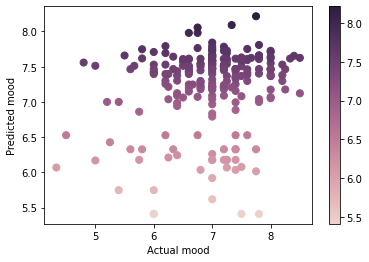

In [589]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(y_test, test_preds, c=test_preds, s=50, cmap=cmap)
ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()

## Random Forest Regression

In [590]:
attributes = df.loc[:, (df.columns != 'mood') | 
                    (df.columns != 'id') | 
                    (df.columns != "Benchmark_mood_pred")].columns
X = df[attributes]
y = df[['mood']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train.values.ravel())
train_preds = rf_model.predict(X_train)

rf_mse = mean_squared_error(y_train, train_preds)
rf_mae = mean_absolute_error(y_train, train_preds)
print("Random Forest training mse = ",rf_mse," & mae = ",rf_mae," & rmse = ", sqrt(rf_mse))

test_preds = rf_model.predict(X_test)

rf_test_mse = mean_squared_error(y_test, test_preds)
rf_test_mae = mean_absolute_error(y_test, test_preds)

print("Random Forest test mse = ",rf_test_mse," & mae = ",rf_test_mae," & rmse = ", sqrt(rf_test_mse))

Random Forest training mse =  0.0002490494235957782  & mae =  0.002060706401770037  & rmse =  0.015781299806916355
Random Forest test mse =  0.00014361368086149515  & mae =  0.0028641703377426326  & rmse =  0.011983892558826417


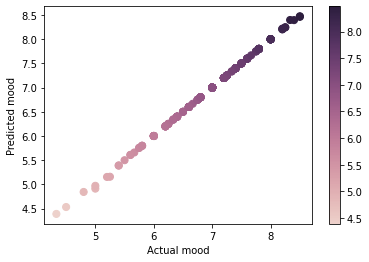

In [591]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(y_test, test_preds, c=test_preds, s=50, cmap=cmap)
ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()

## TO DO
- Tweak performance of random forrest algo? 
- Code the temporal model
- Maybe implement cross validation